In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import dictys
from dictys.net import stat
import joblib

In [2]:
from utils_custom import *

In [3]:
# Define file paths 
output_folder = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output/intermediate_tmp_files'
data_folder = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/dictys_outs/actb1_added_v2/output'

In [4]:
# Load data
dictys_dynamic_object = dictys.net.dynamic_network.from_file(os.path.join(data_folder, 'dynamic.h5'))

# Rank TFs unbiasedly based on their expression and regulation curve chars

In [5]:
gc_top_tfs = ['POU2F3','MYC','IKZF3','IKZF1','PAX5','IRF8','SPIB','BATF3','BHLHE22','E2F2','E2F8','VDR','MYB','SOX4','NFIL3']

In [12]:
# get tf_indices from pb_top_tfs_list
tf_indices_top_gc, tf_gene_indices_top_gc, _ = get_tf_indices(dictys_dynamic_object, gc_top_tfs)
display(tf_gene_indices_top_gc)

[7486,
 6152,
 4506,
 4504,
 6943,
 4655,
 9476,
 919,
 994,
 2817,
 2823,
 11012,
 6147,
 9421,
 6442]

# Get the top genes of TF subnetworks based on the beta curve chars

In [21]:
# load ranked TFs list 
ranked_tfs_pb = pd.read_csv(os.path.join(output_folder, 'ranked_tfs_pb.csv'))
pb_top_tfs = ranked_tfs_pb[0:15]
#convert to list of TF_name
pb_top_tfs_list = pb_top_tfs['TF_name'].tolist()

In [22]:
# get tf_indices from pb_top_tfs_list
tf_indices_top_pb, tf_gene_indices_top_pb, _ = get_tf_indices(dictys_dynamic_object, pb_top_tfs_list)
display(tf_gene_indices_top_pb)

[7604,
 11200,
 997,
 5597,
 8586,
 9419,
 10425,
 11012,
 3133,
 2166,
 2817,
 4926,
 2715,
 4652,
 4927]

#### Plot curves for top TFs in both lineages

In [26]:
dcurve, dtime = compute_expression_regulation_curves(dictys_dynamic_object, start=0, stop=2, num=100, dist=0.0005, mode="regulation")
display(dcurve.shape)

(551, 100)

In [29]:
dcurve_pb_tfs = dcurve.loc[pb_top_tfs_list]
dtime_pb_tfs = dtime
display(dcurve_pb_tfs.shape)

(15, 100)

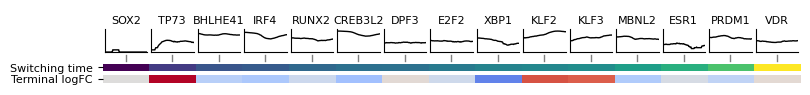

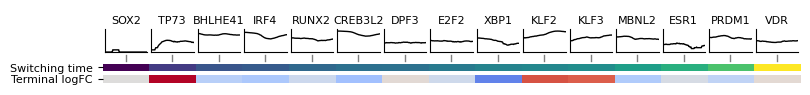

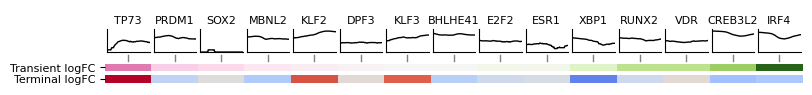

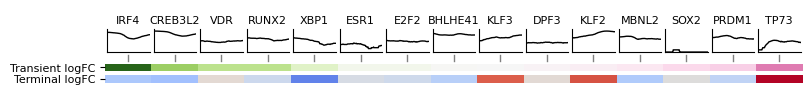

In [30]:
figs=dictys.plot.dynamic.fig_discover(dcurve_pb_tfs, dtime_pb_tfs, ntops=(15,15,15,15))
plt.show()


In [31]:
# get the edge strengths of the top tfs with all relevant genes (dropping genes based on sparsity)
pts, fsmooth = dictys_dynamic_object.linspace(0,2,100,0.0005)
stat1_net = fsmooth(stat.net(dictys_dynamic_object))
stat1_netbin = stat.fbinarize(stat1_net,sparsity=0.01)
stat1_x=stat.pseudotime(dictys_dynamic_object,pts)
dtime = pd.Series(stat1_x.compute(pts)[0])
# compute the binary network to get the indices of genes to keep based on sparsity
dnetbin = stat1_netbin.compute(pts)
display(dnetbin.shape)

(551, 11907, 100)

In [48]:
subnetworks_bin = dnetbin[np.ix_(tf_indices_top_gc, range(dnetbin.shape[1]), range(dnetbin.shape[2]))]
display(subnetworks_bin.shape)

(15, 11907, 100)

In [49]:
# Calculate sparsity for each gene (across all TFs and timepoints)
# Mean across TFs (axis 0) and time (axis 2)
gene_density = (subnetworks_bin != 0).mean(axis=(0, 2))  # Shape: (11907,)
# Keep genes that are non-zero more than 20% of the time
genes_to_keep = gene_density > 0.05
genes_to_keep_indices = np.where(genes_to_keep)[0]
# Create reverse mapping: index -> gene_name
ndict = dictys_dynamic_object.ndict
index_to_gene = {idx: name for name, idx in ndict.items()}
# Get gene names for kept indices directly
kept_target_names = [index_to_gene[idx] for idx in genes_to_keep_indices]
print(len(genes_to_keep_indices))

460


In [52]:
dnet = stat1_net.compute(pts)
display(dnet.shape)

(551, 11907, 100)

In [53]:
# Filter the subnetworks array to keep only non-sparse genes
filtered_subnetworks = dnet[np.ix_(tf_indices_top_gc, genes_to_keep_indices, range(dnet.shape[2]))]
print(filtered_subnetworks.shape)

(15, 460, 100)


In [54]:
# Create multi-index tuples (all combinations of TF-target pairs)
index_tuples = [(tf, target) for tf in gc_top_tfs for target in kept_target_names]
multi_index = pd.MultiIndex.from_tuples(index_tuples, names=['TF', 'Target'])
# Reshape the subnetworks array to 2D (pairs × time points)
n_tfs, n_targets, n_times = filtered_subnetworks.shape
reshaped_data = filtered_subnetworks.reshape(-1, n_times)

# Create DataFrame with multi-index
betas_dcurve = pd.DataFrame(
    reshaped_data,
    index=multi_index,
    columns=[f'time_{i}' for i in range(n_times)]
)
display(betas_dcurve.head())

time_0        time_1        time_2        time_3  \
TF     Target                                                           
POU2F3 AAK1    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
       AATF   -3.819246e-09 -2.597905e-09 -1.758011e-09 -1.183551e-09   
       ABCE1   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
       ACP1    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
       ACSL3   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

                     time_4        time_5        time_6        time_7  \
TF     Target                                                           
POU2F3 AAK1    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
       AATF   -7.927556e-10 -5.283292e-10 -3.503603e-10 -2.312107e-10   
       ABCE1   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
       ACP1    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
       ACSL3   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

                     time_8        time_9  ...       time_90       time_91  \
TF     Target                              ...                               
POU2F3 AAK1    0.000000e+00  0.000000e+00  ...  0.000000e+00  0.000000e+00   
       AATF   -1.518542e-10 -9.927035e-11  ... -5.166912e-34 -2.119588e-34   
       ABCE1   0.000000e+00  0.000000e+00  ...  0.000000e+00  0.000000e+00   
       ACP1    0.000000e+00  0.000000e+00  ...  0.000000e+00  0.000000e+00   
       ACSL3   0.000000e+00  0.000000e+00  ...  0.000000e+00  0.000000e+00   

                    time_92       time_93       time_94       time_95  \
TF     Target                                                           
POU2F3 AAK1    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
       AATF   -8.672407e-35 -3.539371e-35 -1.440920e-35 -5.852066e-36   
       ABCE1   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
       ACP1    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
       ACSL3   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

                    time_96       time_97       time_98       time_99  
TF     Target                                                          
POU2F3 AAK1    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  
       AATF   -2.371167e-36 -9.585739e-37 -3.866571e-37 -1.556286e-37  
       ABCE1   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  
       ACP1    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  
       ACSL3   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  

[5 rows x 100 columns]

In [55]:
import pandas as pd
import numpy as np
from multiprocessing import Pool
import math
from tqdm import tqdm

def process_chunk(args):
    """Process a chunk of curves to compute characteristics"""
    chunk_df, dtime = args
    results = {}
    for idx in chunk_df.index:
        curve = chunk_df.loc[idx]
        char_dict = compute_curve_characteristics(pd.DataFrame(curve).T, dtime)
        results[idx] = char_dict.iloc[0]
    return pd.DataFrame.from_dict(results, orient='index')

# Split data into chunks
n_cores = 8  # Adjust based on your CPU
chunk_size = math.ceil(len(betas_dcurve) / n_cores)
chunks = []

for i in range(0, len(betas_dcurve), chunk_size):
    chunk = betas_dcurve.iloc[i:i + chunk_size]
    chunks.append((chunk, dtime))

# Process chunks in parallel with progress bar
with Pool(n_cores) as pool:
    results = list(tqdm(
        pool.imap(process_chunk, chunks),
        total=len(chunks),
        desc="Processing curves"
    ))

# Combine results and sort
final_dchar = pd.concat(results).sort_index()
#final_dchar.to_csv(os.path.join(output_folder, 'betas_chars_15_647.csv'))


Processing curves: 100%|██████████| 8/8 [00:01<00:00,  5.72it/s]


In [56]:
display(final_dchar.head())

Terminal logFC  Transient logFC  Switching time
BATF3 AAK1         0.000145        -0.002649        0.689341
      AATF         0.000000         0.000000        0.000000
      ABCE1       -0.031618         0.004139        0.414054
      ACP1         0.000000         0.000000        0.000000
      ACSL3        0.000000         0.000000        0.000000

In [57]:
def get_top_curves_by_category(dchar, ntops=(20,20,30,30)):
    """
    Get top curves for different patterns based on Terminal and Transient logFC.
    
    Parameters:
    -----------
    dchar : pd.DataFrame
        DataFrame with curve characteristics, having multi-index (TF, Target)
        and columns ['Terminal logFC', 'Transient logFC', 'Switching time']
    ntops : tuple
        Number of top curves to return for (activating, inactivating, transient_up, transient_down)
    """
    categories = {}
    
    # Activating (positive Terminal logFC)
    t1 = dchar.sort_values('Terminal logFC', ascending=False).head(ntops[0])
    categories['activating'] = t1.sort_values('Switching time')
    
    # Inactivating (negative Terminal logFC)
    t1 = dchar.sort_values('Terminal logFC', ascending=True).head(ntops[1])
    categories['inactivating'] = t1.sort_values('Switching time')
    
    # Transient up
    t1 = dchar.sort_values('Transient logFC', ascending=False).head(ntops[2])
    categories['transient_up'] = t1
    
    # Transient down
    t1 = dchar.sort_values('Transient logFC', ascending=True).head(ntops[3])
    categories['transient_down'] = t1
    
    # Extract TF-target pairs for each category
    activating_pairs = [(idx[0], idx[1]) for idx in categories['activating'].index]
    inactivating_pairs = [(idx[0], idx[1]) for idx in categories['inactivating'].index]
    transient_up_pairs = [(idx[0], idx[1]) for idx in categories['transient_up'].index]
    transient_down_pairs = [(idx[0], idx[1]) for idx in categories['transient_down'].index]
    
    return {
        'activating': activating_pairs,
        'inactivating': inactivating_pairs,
        'transient_up': transient_up_pairs,
        'transient_down': transient_down_pairs
    }

In [58]:
sorted_categories = get_top_curves_by_category(final_dchar, ntops=(20,20,30,30))

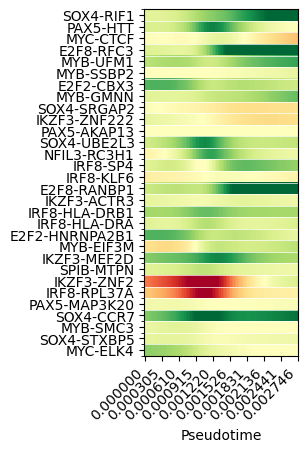

In [59]:
fig, ax, dnet = fig_regulation_heatmap(
    network=dictys_dynamic_object,
    start=0,
    stop=3,
    regulations=sorted_categories['transient_up'],
    num=100,
    dist=0.0005,
    cmap='RdYlGn' #red is low, green is high
)

In [60]:
# Convert dnet to DataFrame with row labels
df = pd.DataFrame(dnet, 
                 index=["-".join(x) for x in sorted_categories['transient_up']])
print("DataFrame values range:", df.values.min(), "to", df.values.max())
# Calculate max absolute value for symmetric color scaling
vmax_val = float(df.abs().values.max())  # Get max from numpy array values

DataFrame values range: -0.210229362841677 to 0.33861743456911136


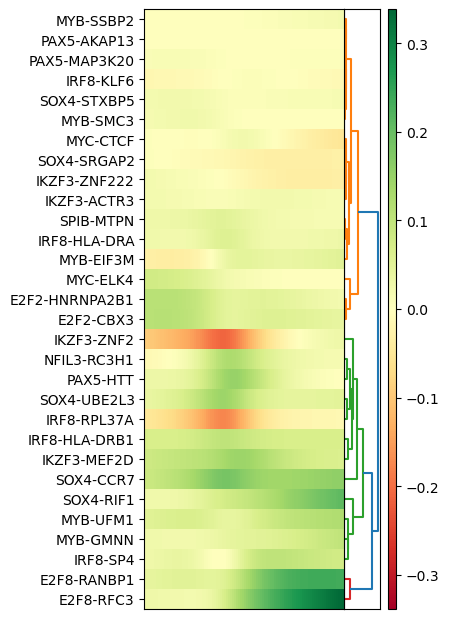

In [61]:
# Use cluster_heatmap with absolute values for clustering
fig, x, y = cluster_heatmap(df.abs(),  # Use absolute values for clustering
                           dshow=df,    # Show original values in heatmap
                           dtop=0,      # No clustering on time points
                           dright=0.3,  # Cluster the links
                           method='ward',
                           metric='euclidean',
                           cmap='RdYlGn',   # Use the colormap name directly
                           aspect=0.1,
                           xtick=False,
                           vmin=-vmax_val,  # Set minimum value
                           vmax=vmax_val)   # Set maximum value

In [61]:
# extarct gene names for pathway analysis
row_labels = df.index
# Extract just the target names from the TF-target pairs
target_names = [pair.split('-')[1] for pair in row_labels]
unique_targets = sorted(set(target_names)) 
print(target_names)

['LDHA', 'DDX21', 'NEDD8', 'DUT', 'UBR5', 'LNPK', 'TMBIM6', 'COX7B', 'SERPINB9', 'RNF34', 'HLA', 'GMPS', 'OSBPL8', 'TMEM126B', 'PSME2', 'USP28', 'MED13L', 'TPM3', 'PKM', 'SIK3', 'SLA', 'FUS', 'CSE1L', 'RRP1B', 'DIAPH1', 'SUB1', 'PKM', 'SLC25A32', 'SPI1', 'CORO1A']


# Geneset regulatory activity

In [91]:
def read_gmt_file(gmt_path):
    """
    Read a GMT file and return a dictionary of gene sets.
    
    Parameters:
    -----------
    gmt_path : str
        Path to the GMT file
        
    Returns:
    --------
    dict : Dictionary with gene set names as keys and gene lists as values
    """
    gene_sets = {}
    with open(gmt_path, 'r') as f:
        for line in f:
            parts = line.strip().split('\t')
            # First field is name, second is description (we'll skip it)
            name = parts[0]
            # Remaining fields are genes
            genes = [g.upper() for g in parts[2:]]  # Convert to uppercase
            gene_sets[name] = genes
    
    return gene_sets

In [96]:
# Load the GMT file
kegg_gmt_file = '/ocean/projects/cis240075p/asachan/datasets/gene_sets/human/KEGG_CELL_CYCLE.v2024.1.Hs.gmt'
gobp_gmt_file = '/ocean/projects/cis240075p/asachan/datasets/gene_sets/human/GOBP_CELL_CYCLE.v2024.1.Hs.gmt'
phase_gmt_file = '/ocean/projects/cis240075p/asachan/datasets/gene_sets/human/CELL_CYCLE_PHASE.v2024.1.Hs.gmt'
# create a list of genes from the dicts
cell_cycle_kegg_genes = list(read_gmt_file(kegg_gmt_file)['KEGG_CELL_CYCLE'])
cell_cycle_gobp_genes = list(read_gmt_file(gobp_gmt_file)['GOBP_CELL_CYCLE'])
cell_cycle_phase_genes = list(read_gmt_file(phase_gmt_file)['CELL_CYCLE_PHASE'])
display(len(cell_cycle_kegg_genes))
display(len(cell_cycle_gobp_genes))
display(len(cell_cycle_phase_genes))


125

1684

170

In [7]:
# load LF files 
z11_file = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/other_files/latent_factors/feature_list_Z11.txt'
z3_file = '/ocean/projects/cis240075p/asachan/datasets/B_Cell/multiome_1st_donor_UPMC_aggr/other_files/latent_factors/feature_list_Z3.txt'

# load into a list of gene names 
z11 = pd.read_csv(z11_file, sep='\t', header=0)
z3 = pd.read_csv(z3_file, sep='\t', header=0)

# get the gene names 
z11_genes = z11['names'].tolist()
z3_genes = z3['names'].tolist()

# create a list of all lf genes 
lf_genes = list(set(z11_genes + z3_genes))


In [8]:
lf_in_object = check_if_gene_in_ndict(dictys_dynamic_object, lf_genes, return_index=True)
print(f"Found {len(lf_in_object['present'])} genes")
print(f"Missing {len(lf_in_object['missing'])} genes")
print("Indices:", lf_in_object['indices'])


Found 68 genes
Missing 0 genes
Indices: {'CDK6': 1665, 'GAB1': 3613, 'HLA-DRB1': 4201, 'AFF3': 230, 'MAPK1': 5543, 'HLA-DMA': 4190, 'HSP90B1': 4304, 'CIITA': 1884, 'TXNDC5': 10727, 'LMAN1': 5269, 'HLA-DPB1': 4195, 'SUB1': 9706, 'CD74': 1586, 'CPEB4': 2131, 'SSR1': 9582, 'JCHAIN': 4730, 'HLA-DQA1': 4196, 'TIAM1': 10070, 'CEP128': 1733, 'TNFAIP8': 10337, 'GLCCI1': 3767, 'TBC1D4': 9887, 'SLC25A13': 9042, 'ELL2': 2979, 'PDE4D': 7027, 'SLAMF7': 8987, 'CD99': 1598, 'HLA-A': 4187, 'DEK': 2479, 'HLA-B': 4188, 'BTG2': 1106, 'PRDM1': 7604, 'MZB1': 6199, 'IRF4': 4652, 'IQGAP2': 4638, 'ARFGAP3': 560, 'FNDC3A': 3516, 'TXNDC11': 10722, 'HM13': 4210, 'RNF213': 8355, 'UBAC2': 10759, 'CTSH': 2270, 'IGHM': 4421, 'CD52': 1574, 'TRAM1': 10472, 'EEA1': 2862, 'SEL1L3': 8763, 'TRAM2': 10473, 'HLA-DPA1': 4194, 'ARNTL2': 665, 'MAN1A1': 5488, 'B2M': 872, 'MED23': 5675, 'CCSER2': 1534, 'ANKRD28': 429, 'PAX5': 6943, 'XBP1': 11200, 'FNDC3B': 3517, 'HLA-DQB1': 4198, 'HLA-C': 4189, 'HLA-DMB': 4191, 'PIM2': 7239, 'CD

In [99]:
kegg_cell_cycle_in_object = check_if_gene_in_ndict(dictys_dynamic_object, cell_cycle_kegg_genes, return_index=True)
print(f"Found {len(kegg_cell_cycle_in_object['present'])} genes")
print(f"Missing {len(kegg_cell_cycle_in_object['missing'])} genes")
print("Indices:", kegg_cell_cycle_in_object['indices'])
# create a list of genes that are in the object from te indices dict keys
kegg_cell_cycle_genes = list(kegg_cell_cycle_in_object['indices'].keys())
display(len(kegg_cell_cycle_genes))
# get lcpm chars for these genes

Found 118 genes
Missing 7 genes
Indices: {'ABL1': 69, 'ANAPC1': 385, 'ANAPC10': 386, 'ANAPC11': 387, 'ANAPC13': 388, 'ANAPC2': 391, 'ANAPC4': 392, 'ANAPC5': 393, 'ANAPC7': 394, 'ATM': 766, 'ATR': 841, 'BUB1': 1116, 'BUB1B': 1117, 'BUB3': 1118, 'CCNA2': 1498, 'CCNB1': 1499, 'CCNB2': 1501, 'CCND1': 1503, 'CCND2': 1504, 'CCND3': 1506, 'CCNE1': 1508, 'CCNE2': 1509, 'CCNH': 1513, 'CDC14A': 1603, 'CDC14B': 1604, 'CDC16': 1605, 'CDC20': 1606, 'CDC23': 1607, 'CDC25A': 1608, 'CDC25B': 1609, 'CDC25C': 1610, 'CDC26': 1611, 'CDC27': 1612, 'CDC45': 1626, 'CDC6': 1628, 'CDC7': 1629, 'CDK1': 1647, 'CDK2': 1657, 'CDK4': 1660, 'CDK6': 1665, 'CDK7': 1666, 'CDKN1A': 1673, 'CDKN1B': 1674, 'CDKN1C': 1675, 'CDKN2A': 1676, 'CDKN2C': 1680, 'CDKN2D': 1681, 'CHEK1': 1826, 'CHEK2': 1827, 'CREBBP': 2168, 'CUL1': 2279, 'DBF4': 2369, 'E2F1': 2816, 'E2F2': 2817, 'E2F3': 2818, 'E2F4': 2819, 'E2F5': 2820, 'EP300': 3053, 'ESPL1': 3132, 'FZR1': 3604, 'GADD45A': 3628, 'GADD45B': 3629, 'GADD45G': 3630, 'GSK3B': 3979, 'HDA

118

## Expression dynamics of the genes

In [11]:
# get lcpm chars for these genes
dcurve_pb, dtime_pb = compute_expression_regulation_curves(dictys_dynamic_object, start=0, stop=2, num=100, dist=0.0005, mode="expression")
# slice the dcurve for the lf genes using gene names which are indices in pandas df
lf_lcpm_dcurve_pb = dcurve_pb.loc[lf_genes]
# get dchars for these genes
lf_lcpm_dchar_pb = compute_curve_characteristics(lf_lcpm_dcurve_pb, dtime_pb)
display(lf_lcpm_dchar_pb)

,Terminal logFC,Transient logFC,Switching time
CDK6,0.992896,-0.089047,0.541787
GAB1,1.587456,0.000000,0.409007
HLA-DRB1,-0.585160,0.036745,0.763643
AFF3,-4.754897,0.016134,0.555120
MAPK1,-1.158736,0.000000,0.425474
...,...,...,...
PPIB,2.298965,-0.154176,0.528370
HLA-DRA,-0.692791,0.000000,0.670680
RUNX2,2.649100,0.000000,0.472686
SLA,1.071827,0.000000,0.269187


In [12]:
# get lcpm chars for these genes
dcurve_gc, dtime_gc = compute_expression_regulation_curves(dictys_dynamic_object, start=0, stop=3, num=100, dist=0.0005, mode="expression")
# slice the dcurve for the lf genes using gene names which are indices in pandas df
lf_lcpm_dcurve_gc = dcurve_gc.loc[lf_genes]
# get dchars for these genes
lf_lcpm_dchar_gc = compute_curve_characteristics(lf_lcpm_dcurve_gc, dtime_gc)
display(lf_lcpm_dchar_gc)

,Terminal logFC,Transient logFC,Switching time
CDK6,0.646495,0.006843,0.355950
GAB1,-0.897141,-0.001339,0.412341
HLA-DRB1,-0.507484,-0.007066,0.374266
AFF3,1.051332,-0.027486,0.609753
MAPK1,0.489347,-0.018021,0.630593
...,...,...,...
PPIB,0.589206,0.071879,0.248676
HLA-DRA,-0.295109,-0.006198,0.339376
RUNX2,-1.146359,0.196928,0.690463
SLA,-0.006380,0.054698,0.500000


#### Choosing the genes which are dynamically divergent in lineages from the LFs

In [13]:
def find_dynamically_opposite_genes(gc_dchar: pd.DataFrame, pb_dchar: pd.DataFrame, min_effect: float = 0.1):
    """
    Find genes with opposite effects between GC and PB lineages by:
    1. Filtering out low effect genes
    2. Normalizing metrics within each condition separately
    3. Finding dominant effect (Terminal/Transient) for each gene in each condition
    4. Comparing signs of dominant effects
    
    Parameters:
    -----------
    gc_dchar, pb_dchar : pd.DataFrame
        DataFrames with 'Terminal logFC' and 'Transient logFC' columns
    min_effect : float
        Minimum absolute effect size threshold for filtering
    
    Returns:
    --------
    list : List of genes with opposite dominant effects between conditions
    """
    # Filter genes with low effect sizes in both conditions
    gc_filtered = gc_dchar[
        (abs(gc_dchar['Terminal logFC']) >= min_effect) | 
        (abs(gc_dchar['Transient logFC']) >= min_effect)
    ].copy()
    
    pb_filtered = pb_dchar[
        (abs(pb_dchar['Terminal logFC']) >= min_effect) | 
        (abs(pb_dchar['Transient logFC']) >= min_effect)
    ].copy()
    
    # Get common genes after filtering
    common_genes = list(set(gc_filtered.index) & set(pb_filtered.index))
    gc_filtered = gc_filtered.loc[common_genes]
    pb_filtered = pb_filtered.loc[common_genes]
    
    # Create normalized versions
    gc_norm = gc_filtered.copy()
    pb_norm = pb_filtered.copy()
    
    # Normalize GC metrics
    gc_terminal_abs = np.abs(gc_filtered['Terminal logFC'])
    gc_terminal_min = gc_terminal_abs.min()
    gc_terminal_max = gc_terminal_abs.max()
    gc_norm['Terminal logFC'] = (gc_terminal_abs - gc_terminal_min) / (gc_terminal_max - gc_terminal_min)
    gc_norm['Terminal logFC'] *= np.sign(gc_filtered['Terminal logFC'])
    
    gc_transient_abs = np.abs(gc_filtered['Transient logFC'])
    gc_transient_min = gc_transient_abs.min()
    gc_transient_max = gc_transient_abs.max()
    gc_norm['Transient logFC'] = (gc_transient_abs - gc_transient_min) / (gc_transient_max - gc_transient_min)
    gc_norm['Transient logFC'] *= np.sign(gc_filtered['Transient logFC'])
    
    # Normalize PB metrics
    pb_terminal_abs = np.abs(pb_filtered['Terminal logFC'])
    pb_terminal_min = pb_terminal_abs.min()
    pb_terminal_max = pb_terminal_abs.max()
    pb_norm['Terminal logFC'] = (pb_terminal_abs - pb_terminal_min) / (pb_terminal_max - pb_terminal_min)
    pb_norm['Terminal logFC'] *= np.sign(pb_filtered['Terminal logFC'])
    
    pb_transient_abs = np.abs(pb_filtered['Transient logFC'])
    pb_transient_min = pb_transient_abs.min()
    pb_transient_max = pb_transient_abs.max()
    pb_norm['Transient logFC'] = (pb_transient_abs - pb_transient_min) / (pb_transient_max - pb_transient_min)
    pb_norm['Transient logFC'] *= np.sign(pb_filtered['Transient logFC'])
    
    opposite_genes = []
    
    # Compare dominant effects for each gene
    for idx in common_genes:
        # Get normalized values
        gc_terminal = gc_norm.at[idx, 'Terminal logFC']
        gc_transient = gc_norm.at[idx, 'Transient logFC']
        pb_terminal = pb_norm.at[idx, 'Terminal logFC']
        pb_transient = pb_norm.at[idx, 'Transient logFC']
        
        # Determine dominant effect for each condition
        gc_dominant_val = gc_terminal if abs(gc_terminal) >= abs(gc_transient) else gc_transient
        pb_dominant_val = pb_terminal if abs(pb_terminal) >= abs(pb_transient) else pb_transient
        
        # Check if dominant effects have opposite signs
        if gc_dominant_val * pb_dominant_val < 0:
            opposite_genes.append(idx)
    return opposite_genes


In [14]:
opposite_genes = find_dynamically_opposite_genes(lf_lcpm_dchar_gc, lf_lcpm_dchar_pb, min_effect=0.3)
display(len(opposite_genes))

21

In [11]:
# order the opposite genes by keeping the upregulated genes first then downregulated genes
opposite_genes_ordered_pb = sorted(opposite_genes, key=lambda x: lf_lcpm_dchar_pb.at[x, 'Terminal logFC'], reverse=True)
opposite_genes_ordered_gc = sorted(opposite_genes, key=lambda x: lf_lcpm_dchar_gc.at[x, 'Terminal logFC'], reverse=True)


#### Genes with the most significant effect size changes per lineage

In [15]:
def get_top_terminal_effect_genes(dchar: pd.DataFrame, n_top: int = 15):
    """
    Get top genes based on their normalized effect sizes.
    
    Parameters:
    -----------
    dchar : pd.DataFrame
        DataFrame with 'Terminal logFC' and 'Transient logFC' columns
    n_top : int
        Number of top genes to return
    
    Returns:
    --------
    list : List of top genes sorted by combined normalized effect size
    """
    # Create normalized version of the dataframe
    norm_dchar = dchar.copy()
    
    # Normalize Terminal logFC
    terminal_abs = np.abs(dchar['Terminal logFC'])
    terminal_min = terminal_abs.min()
    terminal_max = terminal_abs.max()
    norm_dchar['Terminal logFC'] = (terminal_abs - terminal_min) / (terminal_max - terminal_min)
        
    # Sort by combined effect and get top genes
    top_genes = norm_dchar.nlargest(n_top, 'Terminal logFC').index.tolist()
    
    print(f"Top {n_top} genes by effect size:")
    for i, gene in enumerate(top_genes, 1):
        effect = norm_dchar.at[gene, 'Terminal logFC']
        print(f"{i}. {gene}: {effect:.3f}")
    
    return top_genes

In [16]:
# Usage:
top_pb_genes = get_top_terminal_effect_genes(lf_lcpm_dchar_pb, n_top=10)
top_gc_genes = get_top_terminal_effect_genes(lf_lcpm_dchar_gc, n_top=10)

Top 10 genes by effect size:
1. JCHAIN: 1.000
2. AFF3: 0.887
3. PRDM1: 0.859
4. FNDC3B: 0.822
5. TRAM2: 0.681
6. MZB1: 0.675
7. IGHM: 0.638
8. XBP1: 0.614
9. TXNDC5: 0.611
10. TXNDC11: 0.604
Top 10 genes by effect size:
1. JCHAIN: 1.000
2. MED23: 0.685
3. SLAMF7: 0.676
4. BTG2: 0.617
5. TBC1D4: 0.612
6. CD52: 0.609
7. PIM2: 0.576
8. ARNTL2: 0.544
9. RUNX2: 0.515
10. FNDC3B: 0.498


In [17]:
# take a union of top_genes and opposite_genes
dynamic_pb_genes = list(set(top_pb_genes + opposite_genes))
dynamic_gc_genes = list(set(top_gc_genes + opposite_genes))
display(len(dynamic_pb_genes))
display(len(dynamic_gc_genes))
# save the dynamic_pb_genes and dynamic_gc_genes
#np.save(os.path.join(output_folder, 'dynamic_pb_genes.npy'), dynamic_pb_genes)
#np.save(os.path.join(output_folder, 'dynamic_gc_genes.npy'), dynamic_gc_genes)


30

24

In [18]:
# order the dynamic_pb_genes by the switching time
dynamic_pb_genes_ordered = sorted(dynamic_pb_genes, key=lambda x: lf_lcpm_dchar_pb.at[x, 'Switching time'])
dynamic_gc_genes_ordered = sorted(dynamic_gc_genes, key=lambda x: lf_lcpm_dchar_gc.at[x, 'Switching time'])

#### Classification of genes by expression dynamics

In [22]:
lf_classifications, percentiles_used = classify_genes_by_expression_dynamics(lf_lcpm_dchar_pb, ntops=(25, 5, 7, 5))

print("\nEffective percentiles used:")
for category, percentile in percentiles_used.items():
    if percentile is not None:
        print(f"{category}: {percentile:.1f}%")
for category, genes in lf_classifications.items():
    print(f"{category}: {len(genes)} genes")


Effective percentiles used:
up_regulated: 34.2%
transient_up: 37.5%
down_regulated: 58.8%
transient_down: 0.0%
up_regulated: 25 genes
transient_up: 5 genes
down_regulated: 7 genes
transient_down: 5 genes


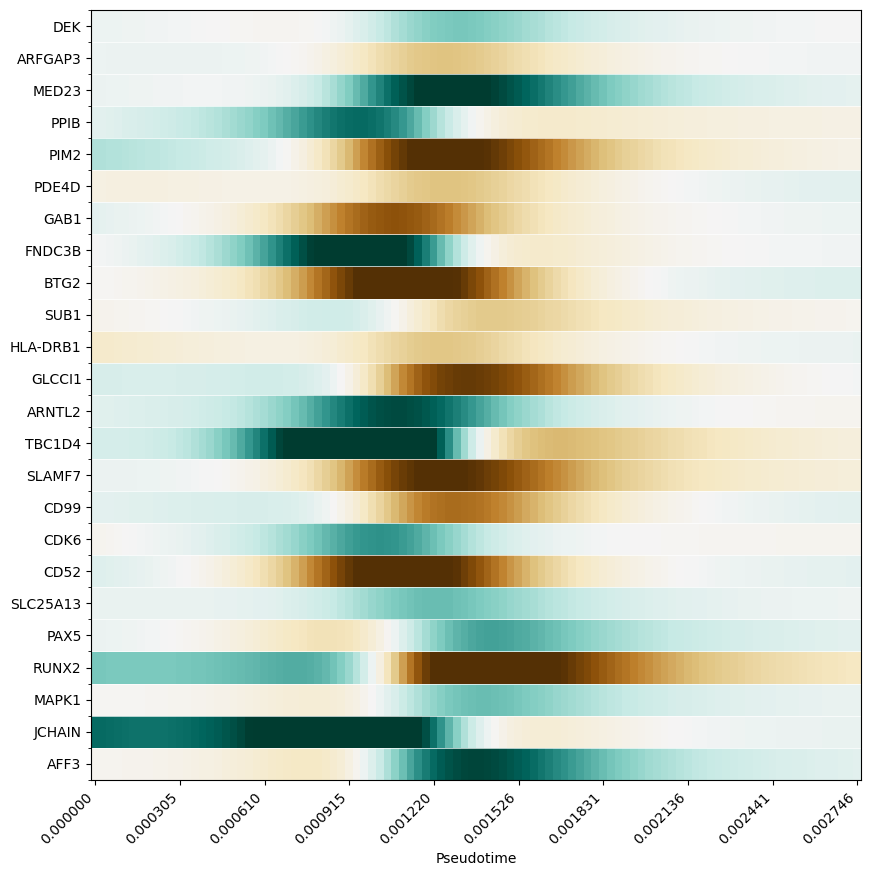

In [204]:
# Create figure for up-regulated genes
fig, ax = plt.subplots(figsize=(10, 10))
# Get genes from the up_regulated category
#transient_down_genes = lf_classifications['transient_down']
# Plot expression gradient for up-regulated genes
fig, ax, cmap = fig_expression_gradient_heatmap(
    network=dictys_dynamic_object,
    start=0,
    stop=3,
    genes_or_regulations=dynamic_gc_genes,
    num=100,
    dist=0.0005,
    ax=ax,
    cmap="BrBG",
    figsize=(10, 0.3)
)

In [23]:
# combine the genes from the classifications into one filtered list
filtered_lf_genes = list(lf_classifications['up_regulated']) + list(lf_classifications['transient_up']) + list(lf_classifications['down_regulated']) + list(lf_classifications['transient_down'])

/tmp/ipykernel_7446/3425436304.py:121: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


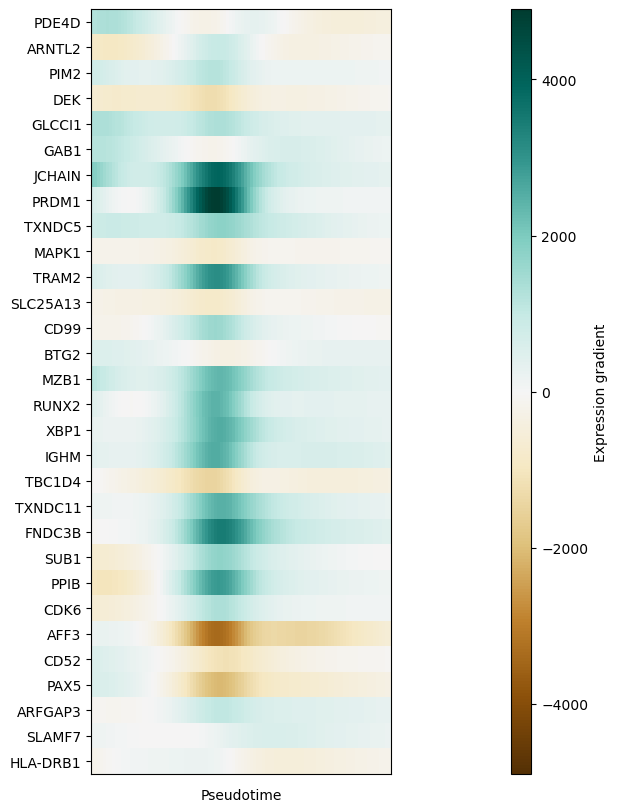

In [205]:
fig, gradients, ordered_genes = fig_clustered_expression_gradient_heatmap(
    network=dictys_dynamic_object,
    start=0,
    stop=2,
    genes_or_regulations=dynamic_pb_genes,
    dchar=lf_lcpm_dchar_pb,
    num=100,
    dist=0.0005,
    cmap='BrBG'
)

## Regulations and beta characteristics

#### Get subnetworks for the dynamic genes in PB lineage

In [19]:
pts, fsmooth = dictys_dynamic_object.linspace(0,2,100,0.0005)
stat1_net = fsmooth(stat.net(dictys_dynamic_object))
stat1_netbin = stat.fbinarize(stat1_net,sparsity=0.01)
stat1_x=stat.pseudotime(dictys_dynamic_object,pts)
dtime = pd.Series(stat1_x.compute(pts)[0])
# compute the binary network to get the indices of genes to keep based on sparsity
dnetbin = stat1_netbin.compute(pts)

In [20]:
dnet = stat1_net.compute(pts)

In [68]:
display(dnetbin.shape)

(551, 11907, 100)

In [21]:
# get indices of the dynamic_pb_genes
dynamic_pb_genes_indices = get_gene_indices(dictys_dynamic_object, dynamic_pb_genes)
display(len(dynamic_pb_genes_indices))  

30

In [22]:
subnetworks_bin = dnetbin[np.ix_(range(dnetbin.shape[0]), dynamic_pb_genes_indices, range(dnetbin.shape[2]))]
display(subnetworks_bin.shape)

(551, 30, 100)

#### Can filter TFs from the entire list (551)

In [23]:
# Calculate sparsity for each TF (across all genes and timepoints)
TF_density = (subnetworks_bin != 0).mean(axis=(1, 2))
# Keep TFs that are non-zero more than x% of the time
TFs_to_keep = TF_density > 0.01
TFs_to_keep_indices = np.where(TFs_to_keep)[0]

# Get TF names
# Create reverse mapping: index -> gene_name
ndict = dictys_dynamic_object.ndict
index_to_gene = {idx: name for name, idx in ndict.items()}
# Get TF_gene_indices from TFs_to_keep_indices using nids[0]
TFs_to_keep_gene_indices = [dictys_dynamic_object.nids[0][tf_idx] for tf_idx in TFs_to_keep_indices]
kept_tf_names = [index_to_gene[idx] for idx in TFs_to_keep_gene_indices]
print(len(kept_tf_names))

220


In [24]:
# Get the subnetworks for the kept TFs
filtered_subnetworks = dnet[np.ix_(TFs_to_keep_indices, dynamic_pb_genes_indices, range(dnet.shape[2]))]
display(filtered_subnetworks.shape)

(220, 30, 100)

#### Get beta dchars for a lineage


In [25]:
# Create multi-index tuples (all combinations of TF-target pairs)
index_tuples = [(tf, target) for tf in kept_tf_names for target in dynamic_pb_genes]
multi_index = pd.MultiIndex.from_tuples(index_tuples, names=['TF', 'Target'])
# Reshape the subnetworks array to 2D (pairs × time points)
n_tfs, n_targets, n_times = filtered_subnetworks.shape
reshaped_data = filtered_subnetworks.reshape(-1, n_times)

# Create DataFrame with multi-index
betas_dcurve_pb = pd.DataFrame(
    reshaped_data,
    index=multi_index,
    columns=[f'time_{i}' for i in range(n_times)]
)
display(betas_dcurve_pb.head())

time_0    time_1    time_2    time_3    time_4    time_5  \
TF  Target                                                               
AHR CDK6    0.020840  0.022763  0.024738  0.026755  0.028797  0.030851   
    GAB1    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    AFF3    0.004407  0.004624  0.004826  0.005011  0.005176  0.005319   
    MAPK1   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
    TXNDC5  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

              time_6    time_7    time_8    time_9  ...       time_90  \
TF  Target                                          ...                 
AHR CDK6    0.032901  0.034931  0.036926  0.038870  ...  3.121211e-08   
    GAB1    0.000000  0.000000  0.000000  0.000000  ...  0.000000e+00   
    AFF3    0.005438  0.005533  0.005602  0.005645  ...  7.604183e-02   
    MAPK1   0.000000  0.000000  0.000000  0.000000  ...  0.000000e+00   
    TXNDC5  0.000000  0.000000  0.000000  0.000000  ...  0.000000e+00   

                 time_91       time_92       time_93       time_94  \
TF  Target                                                           
AHR CDK6    2.097567e-08  1.405991e-08  9.400546e-09  6.269833e-09   
    GAB1    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
    AFF3    7.516530e-02  7.444045e-02  7.387401e-02  7.347084e-02   
    MAPK1   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
    TXNDC5  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

                 time_95       time_96       time_97       time_98  \
TF  Target                                                           
AHR CDK6    4.171757e-09  2.769296e-09  1.834145e-09  1.212098e-09   
    GAB1    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
    AFF3    7.323403e-02  7.316506e-02  7.326388e-02  7.352909e-02   
    MAPK1   0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
    TXNDC5  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   

                 time_99  
TF  Target                
AHR CDK6    7.992956e-10  
    GAB1    0.000000e+00  
    AFF3    7.395806e-02  
    MAPK1   0.000000e+00  
    TXNDC5  0.000000e+00  

[5 rows x 100 columns]

In [31]:
import pandas as pd
import numpy as np
from multiprocessing import Pool
import math
from tqdm import tqdm

def process_chunk(args):
    """Process a chunk of curves to compute characteristics"""
    chunk_df, dtime = args
    results = {}
    for idx in chunk_df.index:
        curve = chunk_df.loc[idx]
        char_dict = compute_curve_characteristics(pd.DataFrame(curve).T, dtime)
        results[idx] = char_dict.iloc[0]
    return pd.DataFrame.from_dict(results, orient='index')

# Split data into chunks
n_cores = 8  # Adjust based on your CPU
chunk_size = math.ceil(len(betas_dcurve_pb) / n_cores)
chunks = []

for i in range(0, len(betas_dcurve_pb), chunk_size):
    chunk = betas_dcurve_pb.iloc[i:i + chunk_size]
    chunks.append((chunk, dtime))

# Process chunks in parallel with progress bar
with Pool(n_cores) as pool:
    results = list(tqdm(
        pool.imap(process_chunk, chunks),
        total=len(chunks),
        desc="Processing curves"
    ))

# Combine results and sort
beta_chars_pb_sliced = pd.concat(results).sort_index()
beta_chars_pb_sliced.to_csv(os.path.join(output_folder, 'betas_chars_pb_220_30.csv'))


Processing curves: 100%|██████████| 8/8 [00:01<00:00,  7.28it/s]


#### Normalize the beta dchars

In [28]:
def normalize_and_rank_regulations(df):
    """
    Normalize regulations to [-1, 1] scale and rank by absolute effect size.
    """
    # Create copy
    df_norm = df.copy()
    
    # Normalize Terminal logFC to [-1, 1]
    terminal_max = max(abs(df['Terminal logFC'].min()), abs(df['Terminal logFC'].max()))
    df_norm['norm_Terminal'] = df['Terminal logFC'] / terminal_max if terminal_max != 0 else 0
    
    # Normalize Transient logFC to [-1, 1]
    transient_max = max(abs(df['Transient logFC'].min()), abs(df['Transient logFC'].max()))
    df_norm['norm_Transient'] = df['Transient logFC'] / transient_max if transient_max != 0 else 0
    
    # Get maximum absolute effect (for ranking)
    df_norm['max_abs_effect'] = df_norm[['norm_Terminal', 'norm_Transient']].abs().max(axis=1)
    
    # Rank based on absolute effect size
    df_norm['regulation_rank'] = df_norm['max_abs_effect'].rank(ascending=False)
    
    # Sort by rank
    df_norm = df_norm.sort_values('regulation_rank')
    return df_norm

def get_top_regulations(df, n_top=10, effect_type='positive'):
    """
    Get top positive, negative, or all/both regulations based on normalized effect size.
    """
    if effect_type == 'positive':
        mask = (df['norm_Terminal'] > 0) | (df['norm_Transient'] > 0)
    elif effect_type == 'negative':
        mask = (df['norm_Terminal'] < 0) | (df['norm_Transient'] < 0)
    else:
        mask = slice(None)
        
    filtered_df = df[mask] if effect_type != 'all' else df
    top_regs = filtered_df.nlargest(n_top, 'max_abs_effect')
    return top_regs

In [28]:
normalized_dchar_pb = normalize_and_rank_regulations(final_dchar_pb)
# Get top positive regulations
top_positive_pb = get_top_regulations(normalized_dchar_pb, n_top=20, effect_type='positive')

In [29]:
# Standard scientific Python imports
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

def cluster_regulations_by_time(df, n_clusters=3):
    """
    Cluster regulations by switching time and return TF-target tuples per cluster.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with multi-index (TF, target) and 'Switching time' column
    n_clusters : int
        Number of clusters to create
    
    Returns:
    --------
    dict : Dictionary of TF-target tuples for each cluster
    """
    # Prepare switching time data for clustering
    X = df['Switching time'].values.reshape(-1, 1)
    
    # Scale the data
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    df = df.copy()
    df['cluster'] = kmeans.fit_predict(X_scaled)
    
    # Sort clusters by their mean switching time
    cluster_means = df.groupby('cluster')['Switching time'].mean()
    cluster_order = cluster_means.sort_values().index
    cluster_map = {old: new for new, old in enumerate(cluster_order)}
    df['cluster'] = df['cluster'].map(cluster_map)
    
    # Create dictionary for results
    cluster_tuples = {}
    
    # Process each cluster
    for i in range(n_clusters):
        cluster_df = df[df['cluster'] == i]
        
        # Get tuples from multi-index
        tuples = [(idx[0], idx[1]) for idx in cluster_df.index if isinstance(idx, tuple)]
        cluster_tuples[f'cluster_{i}'] = tuples
    return cluster_tuples

In [30]:
# Usage:
regulation_clusters = cluster_regulations_by_time(top_positive_pb, n_clusters=3)

# Access tuples for each timing cluster
early_regulations = regulation_clusters['cluster_0']  # Early regulations
mid_regulations = regulation_clusters['cluster_1']    # Mid-time regulations
late_regulations = regulation_clusters['cluster_2']   # Late regulations
display(early_regulations)


[('CREB3L2', 'PRDM1'),
 ('KLF3', 'JCHAIN'),
 ('KLF3', 'PIM2'),
 ('IRF4', 'FNDC3B')]

In [31]:
# join the early, mid, and late regulations lists
top_clustered_regulations_pb = list(early_regulations) + list(mid_regulations) + list(late_regulations)
display(top_clustered_regulations_pb)


[('CREB3L2', 'PRDM1'),
 ('KLF3', 'JCHAIN'),
 ('KLF3', 'PIM2'),
 ('IRF4', 'FNDC3B'),
 ('RUNX2', 'FNDC3B'),
 ('IRF4', 'CDK6'),
 ('BHLHE41', 'PRDM1'),
 ('PRDM1', 'AFF3'),
 ('CREB3L2', 'TXNDC5'),
 ('IRF4', 'HLA-DRB1'),
 ('CREB3L2', 'MZB1'),
 ('KLF2', 'XBP1'),
 ('KLF2', 'PPIB'),
 ('DPF3', 'HLA-DRB1'),
 ('IRF4', 'PDE4D'),
 ('IRF4', 'GAB1'),
 ('KLF2', 'TXNDC11'),
 ('KLF2', 'SUB1'),
 ('PRDM1', 'CD99'),
 ('VDR', 'PPIB')]

In [32]:
top_clustered_regulations_pb = [('BHLHE41', 'PRDM1'),('IRF4', 'CDK6'),('PRDM1', 'AFF3'),('CREB3L2', 'MZB1'),('CREB3L2', 'TXNDC5'),('PRDM1', 'CD99'),('KLF3', 'JCHAIN'),('IRF4', 'FNDC3B'),('VDR', 'PPIB'),('KLF3', 'PIM2'),('CREB3L2', 'PRDM1'),('RUNX2', 'FNDC3B'),('IRF4', 'PDE4D'),('KLF2', 'SUB1'),('KLF2', 'TXNDC11'),('KLF2', 'PPIB'),('IRF4', 'GAB1'),('KLF2', 'XBP1'),('DPF3', 'HLA-DRB1'),('IRF4', 'HLA-DRB1')]

In [35]:
# get the beta curve for the top_clustered_regulations_pb
top_clustered_regulations_pb_dcurve = betas_dcurve_pb.loc[top_clustered_regulations_pb]
display(top_clustered_regulations_pb_dcurve.head())


time_0    time_1    time_2    time_3    time_4    time_5  \
TF      Target                                                               
BHLHE41 PRDM1  -0.104558 -0.107597 -0.110278 -0.112580 -0.114487 -0.115988   
IRF4    CDK6    0.179421  0.181993  0.184238  0.186157  0.187756  0.189046   
PRDM1   AFF3   -0.069573 -0.072455 -0.075463 -0.078589 -0.081825 -0.085159   
CREB3L2 MZB1    0.016705  0.018608  0.020698  0.022984  0.025473  0.028171   
        TXNDC5  0.086301  0.086546  0.086450  0.086026  0.085295  0.084281   

                  time_6    time_7    time_8    time_9  ...       time_90  \
TF      Target                                          ...                 
BHLHE41 PRDM1  -0.117078 -0.117758 -0.118035 -0.117920  ...  1.042625e-01   
IRF4    CDK6    0.190042  0.190761  0.191221  0.191444  ... -3.307450e-03   
PRDM1   AFF3   -0.088577 -0.092062 -0.095597 -0.099163  ... -1.782157e-07   
CREB3L2 MZB1    0.031084  0.034217  0.037575  0.041161  ...  3.112532e-05   
        TXNDC5  0.083015  0.081531  0.079868  0.078064  ...  6.612076e-02   

                     time_91       time_92       time_93       time_94  \
TF      Target                                                           
BHLHE41 PRDM1   1.018296e-01  9.914910e-02  9.623567e-02  9.310269e-02   
IRF4    CDK6   -3.373738e-03 -3.417380e-03 -3.439685e-03 -3.442095e-03   
PRDM1   AFF3   -1.217074e-07 -8.291446e-08 -5.635279e-08 -3.821211e-08   
CREB3L2 MZB1    2.328897e-05  1.738254e-05  1.294283e-05  9.614465e-06   
        TXNDC5  6.638897e-02  6.659387e-02  6.672559e-02  6.677605e-02   

                     time_95       time_96       time_97       time_98  \
TF      Target                                                           
BHLHE41 PRDM1   8.976227e-02  8.622548e-02  8.250246e-02  7.860260e-02   
IRF4    CDK6   -3.426152e-03 -3.393467e-03 -3.345689e-03 -3.284476e-03   
PRDM1   AFF3   -2.585324e-08 -1.745356e-08 -1.175803e-08 -7.904835e-09   
CREB3L2 MZB1    7.125680e-06  5.269360e-06  3.888162e-06  2.862923e-06   
        TXNDC5  6.673891e-02  6.660943e-02  6.638440e-02  6.606203e-02   

                     time_99  
TF      Target                
BHLHE41 PRDM1   7.453469e-02  
IRF4    CDK6   -3.211473e-03  
PRDM1   AFF3   -5.303756e-09  
CREB3L2 MZB1    2.103671e-06  
        TXNDC5  6.564181e-02  

[5 rows x 100 columns]

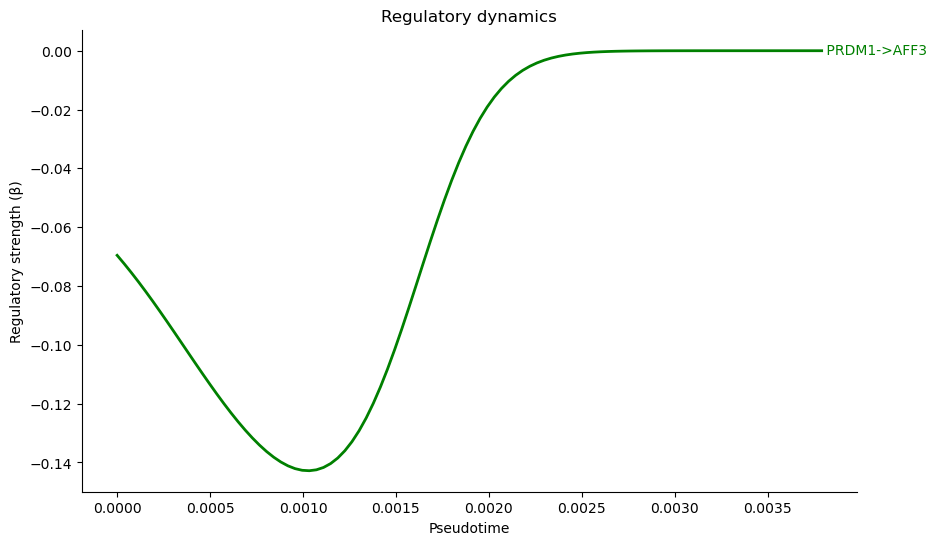

In [38]:
# Plot beta trajectories
fig = plt.figure(figsize=(10, 6))
ax = plt.gca()  # Get current axes

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Specify TF-target pairs of interest
regulations_of_interest = [('PRDM1', 'AFF3')]
colors = ['green']   # Define colors for each regulation

for (tf, target), color in zip(regulations_of_interest, colors):
    # Create multi-index key for the regulation
    idx = pd.MultiIndex.from_tuples([(tf, target)])
    if (tf, target) in betas_dcurve_pb.index:
        line = plt.plot(dtime, betas_dcurve_pb.loc[(tf, target)], 
                       linewidth=2, color=color)
        # Add label at the end of the line
        plt.text(dtime.iloc[-1], 
                betas_dcurve_pb.loc[(tf, target)].iloc[-1], 
                f' {tf}->{target}', 
                color=color, 
                verticalalignment='center')

plt.xlabel('Pseudotime')
plt.ylabel('Regulatory strength (β)')
plt.title('Regulatory dynamics')
plt.show()

In [ ]:
fig, ax, dnet = fig_regulation_heatmap(
    network=dictys_dynamic_object,
    start=0,
    stop=2,
    regulations=top_clustered_regulations_pb,
    num=100,
    dist=0.0005,
    cmap='RdYlGn'
)

In [46]:
# Convert dnet to DataFrame with row labels
df = pd.DataFrame(dnet, 
                 index=["-".join(x) for x in top_clustered_regulations_pb])
print("DataFrame values range:", df.values.min(), "to", df.values.max())
# Calculate max absolute value for symmetric color scaling
vmax_val = float(df.abs().values.max())  # Get max from numpy array values

DataFrame values range: -0.2761862343716693 to 0.2556626735328473


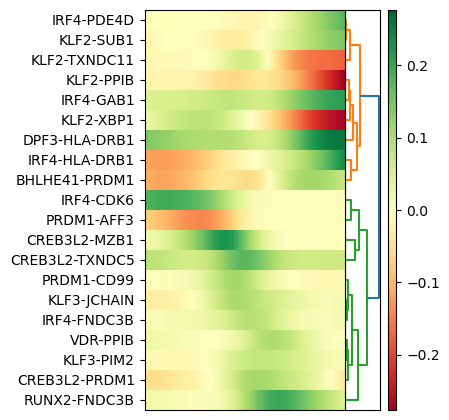

In [47]:
# Use cluster_heatmap with absolute values for clustering
fig, x, y = cluster_heatmap(df.abs(),  # Use absolute values for clustering
                           dshow=df,    # Show original values in heatmap
                           dtop=0,      # No clustering on time points
                           dright=0.3,  # Cluster the links
                           method='ward',
                           metric='euclidean',
                           cmap='RdYlGn',   # Use the colormap name directly
                           aspect=0.1,
                           xtick=False,
                           vmin=-vmax_val,  # Set minimum value
                           vmax=vmax_val)   # Set maximum value

#### Plot expression of targets shown in the regulation heatmap

In [7]:
# extract the targets from the top_clustered_regulations_pb
targets_in_pb_regulations = [x[1] for x in top_clustered_regulations_pb]
# make them unique and maintain order
targets_in_pb_regulations = list(dict.fromkeys(targets_in_pb_regulations))
display(targets_in_pb_regulations)

['PRDM1',
 'CDK6',
 'AFF3',
 'MZB1',
 'TXNDC5',
 'CD99',
 'JCHAIN',
 'FNDC3B',
 'PPIB',
 'PIM2',
 'PDE4D',
 'SUB1',
 'TXNDC11',
 'GAB1',
 'XBP1',
 'HLA-DRB1']

In [83]:
def fig_expression_linear_heatmap(
    network: dictys.net.dynamic_network,
    start: int,
    stop: int,
    genes_or_regulations: Union[list[str], list[Tuple[str, str]]],
    num: int = 100,
    dist: float = 1.5,
    ax: Optional[matplotlib.axes.Axes] = None,
    cmap: Union[str, matplotlib.cm.ScalarMappable] = "coolwarm",
    figsize: Tuple[float, float] = (2, 0.15)
) -> Tuple[matplotlib.pyplot.Figure, matplotlib.axes.Axes, matplotlib.cm.ScalarMappable]:
    """
    Draws pseudo-time dependent heatmap of linear expression values.
    """
    # Get expression data
    pts, fsmooth = network.linspace(start, stop, num, dist)
    stat1_y = fsmooth(stat.lcpm(network, cut=0))
    stat1_x = stat.pseudotime(network, pts)
    
    # Get log2 expression values and convert to linear
    dy = pd.DataFrame(stat1_y.compute(pts), index=stat1_y.names[0])
    dx = pd.Series(stat1_x.compute(pts)[0])
    dy_linear = dy.apply(lambda x: 2**x - 1)
    
    # Get target genes
    if isinstance(genes_or_regulations[0], tuple):
        target_genes = [target for _, target in genes_or_regulations]
        target_genes = list(dict.fromkeys(target_genes))
    else:
        target_genes = list(dict.fromkeys(genes_or_regulations))
    
    # Stack expression values
    expression_matrix = np.vstack([
        dy_linear.loc[gene].values 
        for gene in target_genes
    ])
    
    # Create figure and axes
    if ax is None:
        figsize = (figsize[0], figsize[1] * len(target_genes))
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(111)
    else:
        fig = ax.get_figure()
        figsize = fig.get_size_inches()
    
    aspect = (figsize[1] / len(target_genes)) / (figsize[0] / expression_matrix.shape[1])
    
    # Create heatmap
    if isinstance(cmap, str):
        vmax = np.quantile(expression_matrix.ravel(), 0.95)
        cmap = matplotlib.cm.ScalarMappable(
            norm=matplotlib.colors.Normalize(vmin=0, vmax=vmax), 
            cmap=cmap
        )
    
    if hasattr(cmap, "to_rgba"):
        im = ax.imshow(cmap.to_rgba(expression_matrix), aspect=aspect, interpolation='none')
    else:
        im = ax.imshow(expression_matrix, aspect=aspect, interpolation='none', cmap=cmap)
        plt.colorbar(im, label="Expression (CPM)")
    

    # Set pseudotime labels with rounded values
    ax.set_xlabel("Pseudotime")
    num_ticks = 10
    tick_positions = np.linspace(0, expression_matrix.shape[1] - 1, num_ticks, dtype=int)
    tick_labels = dx.iloc[tick_positions]
    ax.set_xticks(tick_positions)
    ax.set_xticklabels([f"{x:.3f}" for x in tick_labels], rotation=45, ha="right")  # Round to 1 decimal place
    
    # Set gene labels
    ax.set_yticks(list(range(len(target_genes))))
    ax.set_yticklabels(target_genes)
    
    # Add grid lines
    ax.set_yticks(np.arange(len(target_genes) + 1) - 0.5, minor=True)
    ax.grid(which="minor", color="w", linestyle="-", linewidth=0.5)
    
    return fig, ax, cmap

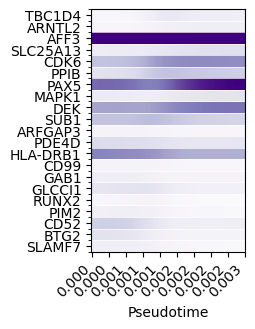

In [75]:
fig, ax, cmap = fig_expression_linear_heatmap(
    network=dictys_dynamic_object,
    start=0,
    stop=3,
    genes_or_regulations=opposite_genes_ordered_gc,
    num=100,
    dist=0.0005,
    cmap='Purples'
)
plt.show()


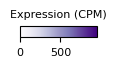

In [76]:
# Create matching colorbar
from dictys.plot import colorbar
fs = 8  # font size to match fig_discover style

ans2 = colorbar(
    cmap, 
    orientation='horizontal',
    figsize=(1, 0.15),
    title='Expression (CPM)',
    title_fontsize=fs
)
ans2[1].tick_params(axis='x', labelsize=fs)
plt.show()

## Getting the top regulations for a geneset
### 1. Per-gene scale normalise and select the top 20 regulations (these explain the curvature of the target gene-expression best)
### 2. Union over the TFs over all the genes in the geneset for that lineage, and get expression chars for the TFs
### 3. Cluster the TFs based on when they peak in regulatory activity (tf expression, tf regulatory activity and individual tf-target regulations are pretty correlated in time)???
### 4. Per cluster of TFs: Pick the top 10% of scale-normalised regulations from the set of regulations in that cluster??

In [33]:
import pandas as pd
import multiprocessing as mp
from functools import partial

def process_target_gene(target_gene, full_df):
    """
    Process a single target gene's regulations
    """
    # Slice regulations for this target
    target_regulations = full_df.loc[full_df.index.get_level_values(1) == target_gene]
    # Normalize and rank
    normalized_regs = normalize_and_rank_regulations(target_regulations)
    # Get top 20 regulations
    top_regs = get_top_regulations(normalized_regs, n_top=20, effect_type='all')
    # Select only the required columns from the original data
    selected_columns = ['Terminal logFC', 'Transient logFC', 'Switching time']
    top_regs_final = full_df.loc[top_regs.index][selected_columns]
    return top_regs_final

def normalize_all_targets(beta_chars_df, n_processes=None):
    """
    Normalize regulations for all target genes and retain top 20 per target.
    """
    # Get unique target genes from index level 1
    target_genes = beta_chars_df.index.get_level_values(1).unique()
    
    # Set up multiprocessing pool
    if n_processes is None:
        n_processes = mp.cpu_count() - 1  # Leave one CPU free
    
    # Create partial function with fixed full_df argument
    process_func = partial(process_target_gene, full_df=beta_chars_df)
    
    # Process all targets in parallel
    with mp.Pool(processes=n_processes) as pool:
        results = pool.map(process_func, target_genes)
    
    # Combine all results
    combined_results = pd.concat(results)
    return combined_results

In [34]:
# Process all targets
top_regulations = normalize_all_targets(beta_chars_pb_sliced)

# Display results
print(f"Total regulations in final dataset: {len(top_regulations)}")
print("\nFirst few rows of top regulations:")
display(top_regulations.head())

Total regulations in final dataset: 600

First few rows of top regulations:


,,Terminal logFC,Transient logFC,Switching time
CTCF,AFF3,0.212416,0.009431,0.555269
ZNF449,AFF3,-0.004753,-0.073719,0.151220
TCF12,AFF3,-0.202170,-0.000752,0.316409
NRF1,AFF3,0.194373,0.001621,0.294951
RUNX3,AFF3,0.169097,-0.001666,0.459045


In [35]:
# Query regulations for AFF3 and convert to list of tuples
target_gene = 'AFF3'
target_regulations = top_regulations.loc[top_regulations.index.get_level_values(1) == target_gene]
target_regulation_pairs = [(str(tf), target) for tf, target in target_regulations.index]

# Display results
print(target_regulation_pairs)

[('CTCF', 'AFF3'), ('ZNF449', 'AFF3'), ('TCF12', 'AFF3'), ('NRF1', 'AFF3'), ('RUNX3', 'AFF3'), ('REL', 'AFF3'), ('NFATC2', 'AFF3'), ('ZNF2', 'AFF3'), ('STAT4', 'AFF3'), ('ZNF100', 'AFF3'), ('ZNF770', 'AFF3'), ('LIN54', 'AFF3'), ('NFATC3', 'AFF3'), ('ZNF154', 'AFF3'), ('ZNF519', 'AFF3'), ('SPIB', 'AFF3'), ('PRDM1', 'AFF3'), ('AHR', 'AFF3'), ('ZNF846', 'AFF3'), ('STAT2', 'AFF3')]


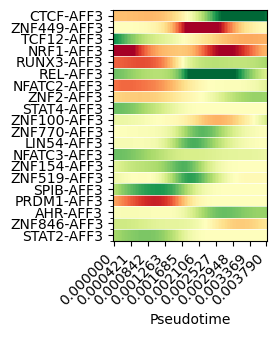

In [36]:
fig, ax, dnet = fig_regulation_heatmap(
    network=dictys_dynamic_object,
    start=0,
    stop=2,
    regulations=target_regulation_pairs,
    num=100,
    dist=0.0005,
    cmap='RdYlGn'
)

In [37]:
# slice the curve of RUNX2 expression 
target_dcurve = dcurve_pb.loc['AFF3']

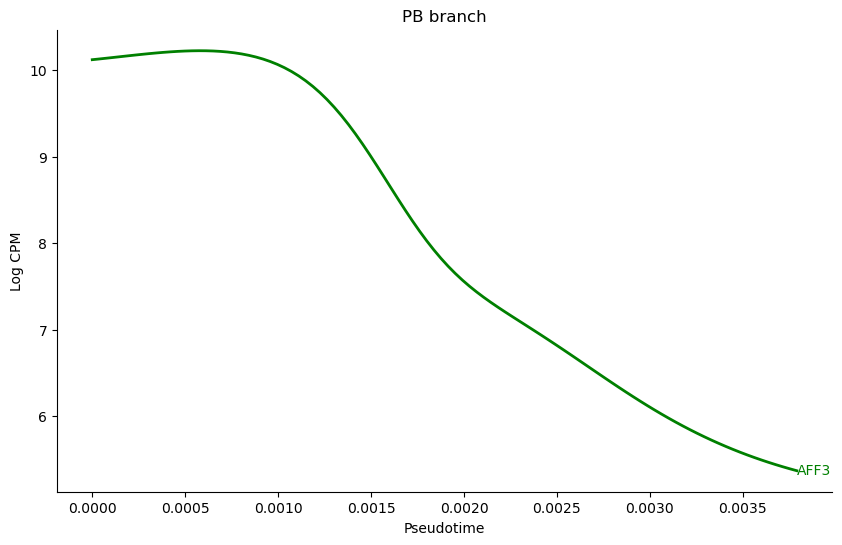

In [40]:
# Plot expression trajectories
fig = plt.figure(figsize=(10, 6))
ax = plt.gca()  # Get current axes

# Remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

color = 'green'
line = plt.plot(dtime, target_dcurve, linewidth=2, color=color)
# Add label at the end of the line
plt.text(dtime.iloc[-1], target_dcurve.iloc[-1], target_gene, 
                color=color, 
                verticalalignment='center')

plt.xlabel('Pseudotime')
plt.ylabel('Log CPM')
plt.title('PB branch')
plt.show()